In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from torchvision import transforms

class SimpleImageDataset(Dataset):
    def __init__(self,main_folder_path, transform=None):
        self.main_folder_path = main_folder_path
        self.transform = transform
        self.x,self.y = self.file_reader()
        
        print(self.y)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        image = Image.open(self.x[idx])
        if self.transform:
            image = self.transform(image)
        label = self.y[idx]
        return image, label


    def data_label(self,folder_name):
        match folder_name:
            case "man":
                 return 0
            case "woman":
                return 1
            case _:
                return None

    def file_reader(self):
        x = []  
        y = [] 

       
        for folder_name in os.listdir(self.main_folder_path):        
            folder_path = os.path.join(self.main_folder_path, folder_name)
            if os.path.isdir(folder_path):
                label = self.data_label(folder_name)
                if label is None:
                    continue
                c=0
                for sub_folder_name in os.listdir(folder_path):
                    final_image=os.path.join(folder_path,sub_folder_name) 
                    if c==20:
                        break

                    print(final_image)
                    x.append(final_image) 
                    c=c+1
                    y.append(label)
        return x,torch.tensor(y)
                        

    

class ConNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ConNN, self).__init__()
        self.conv1=nn.Conv2d(3,16,2)
        self.pool=nn.MaxPool2d(2,2)
        self.conv2=nn.Conv2d(16,32,2)
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) 
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.fc3(x)
        return x



transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((8,8)), 
    transforms.ToTensor(),        
    
    
])

In [2]:
main_folder_path ='/kaggle/input/biggest-genderface-recognition-dataset/faces'
dataset = SimpleImageDataset(main_folder_path, transform=transform)
train_loader = DataLoader(dataset, batch_size=2, shuffle=True)
input_size = 32*1*1
hidden_size = 2*input_size
output_size = 2
model = ConNN(input_size, hidden_size, output_size)

/kaggle/input/biggest-genderface-recognition-dataset/faces/man/man_4160.jpg
/kaggle/input/biggest-genderface-recognition-dataset/faces/man/man_16738.jpg
/kaggle/input/biggest-genderface-recognition-dataset/faces/man/man_4001.jpg
/kaggle/input/biggest-genderface-recognition-dataset/faces/man/man_4435.jpg
/kaggle/input/biggest-genderface-recognition-dataset/faces/man/man_12722.jpg
/kaggle/input/biggest-genderface-recognition-dataset/faces/man/man_16251.jpg
/kaggle/input/biggest-genderface-recognition-dataset/faces/man/man_17245.jpg
/kaggle/input/biggest-genderface-recognition-dataset/faces/man/man_10765.jpg
/kaggle/input/biggest-genderface-recognition-dataset/faces/man/man_4530.jpg
/kaggle/input/biggest-genderface-recognition-dataset/faces/man/man_5505.jpg
/kaggle/input/biggest-genderface-recognition-dataset/faces/man/man_4973.jpg
/kaggle/input/biggest-genderface-recognition-dataset/faces/man/man_4834.jpg
/kaggle/input/biggest-genderface-recognition-dataset/faces/man/man_2513.jpg
/kaggle

In [3]:
dataset[1]

(tensor([[[0.4392, 0.4353, 0.5647, 0.4588, 0.2471, 0.2745, 0.2902, 0.4667],
          [0.4431, 0.4314, 0.3647, 0.2588, 0.2000, 0.3216, 0.4314, 0.5176],
          [0.4510, 0.3843, 0.2824, 0.4078, 0.3373, 0.2784, 0.6196, 0.5843],
          [0.4627, 0.4078, 0.3059, 0.3294, 0.3255, 0.4078, 0.6510, 0.5882],
          [0.4667, 0.4431, 0.3922, 0.3216, 0.3490, 0.4471, 0.6431, 0.5843],
          [0.4745, 0.4588, 0.3137, 0.1961, 0.1647, 0.2078, 0.4549, 0.4941],
          [0.4549, 0.3176, 0.2627, 0.2196, 0.1922, 0.0471, 0.0588, 0.1020],
          [0.3608, 0.0863, 0.1725, 0.2667, 0.0784, 0.0353, 0.0392, 0.0431]],
 
         [[0.4392, 0.4353, 0.5647, 0.4588, 0.2471, 0.2745, 0.2902, 0.4667],
          [0.4431, 0.4314, 0.3647, 0.2588, 0.2000, 0.3216, 0.4314, 0.5176],
          [0.4510, 0.3843, 0.2824, 0.4078, 0.3373, 0.2784, 0.6196, 0.5843],
          [0.4627, 0.4078, 0.3059, 0.3294, 0.3255, 0.4078, 0.6510, 0.5882],
          [0.4667, 0.4431, 0.3922, 0.3216, 0.3490, 0.4471, 0.6431, 0.5843],
         

In [4]:

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
num_epochs = 20
for epoch in range(num_epochs):
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        err = loss(outputs, labels)
        err.backward()
        optimizer.step()
    if epoch%1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {err.item():.4f}')

Epoch [1/20], Loss: 0.7397
Epoch [2/20], Loss: 0.6883
Epoch [3/20], Loss: 0.7216
Epoch [4/20], Loss: 0.7334
Epoch [5/20], Loss: 0.6992
Epoch [6/20], Loss: 0.6924
Epoch [7/20], Loss: 0.6886
Epoch [8/20], Loss: 0.6892
Epoch [9/20], Loss: 0.6867
Epoch [10/20], Loss: 0.6984
Epoch [11/20], Loss: 0.6916
Epoch [12/20], Loss: 0.6614
Epoch [13/20], Loss: 0.6933
Epoch [14/20], Loss: 0.6812
Epoch [15/20], Loss: 0.8304
Epoch [16/20], Loss: 0.6978
Epoch [17/20], Loss: 0.7698
Epoch [18/20], Loss: 0.6669
Epoch [19/20], Loss: 1.1512
Epoch [20/20], Loss: 0.7605


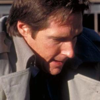

In [6]:
model.eval()
from PIL import Image
image_path = '/kaggle/input/biggest-genderface-recognition-dataset/faces/man/man_1000.jpg'
image = Image.open(image_path)
image

In [7]:
image = transform(image).unsqueeze(0)


with torch.no_grad():
    output = model(image)

_, predicted_class = torch.max(output, 1)
dictt = {
    0: "men",
    1: "women",
    
}
print(f'Predicted class: {dictt[predicted_class.item()]}')

Predicted class: men
